MVA 2021 ENS Paris-Saclay

Elías MASQUIL

# Barrier method for optimizing LASSO


We have the following problem:

\begin{equation}
  \tag{LASSO}
\text{minimize } \frac{1}{2}||Xw-y||_2^2+λ||w||_1
\end{equation}
in the variable $w \in \mathbb{R}^d$, where $X=(x_1^T, ..., x_n^T) \in \mathbb{R}^{n\times d}, y=(y1, ..., y_n) \in \mathbb{R}^n \text{ and } \lambda>0$ is a regularization parameter.

## Derive the dual problem of LASSO and format it as a general Quadratic Problem
\begin{equation}
\tag{QP}
\text{minimize } v^TQv + p^Tv \\
\text{s.t } Av \preccurlyeq b
\end{equation}
in variable $v \in \mathbb{R}^n$, where $Q \succcurlyeq 0$

Let's begin by adding an equality constraint to form the dual problem:

\begin{align}
\min_{z,w} \frac{1}{2} ||z||_2^2 + \lambda||w||_1 \\
\text{s.t } z=Xw-y
\end{align}

Then, the Lagrangian and the dual function are:
\begin{align}
L(w,z,\mu) = \frac{1}{2}||z||_2^2 + \lambda ||w||_1 + \mu^T(z-Xw+y) \\
g(\mu) = \inf_{w,z} L(w,z,\mu) = \inf_z (\frac{1}{2}||z||_2^2 + \mu^Tz) + \inf_w(\lambda ||w||_1 - \mu^TXw) + \mu^Ty
\end{align}

The infimum in $z$ can be found by using the first order condition $\nabla f(z)=0$ since we have a convex function on $z$:
\begin{align}
\nabla f(z) = z + \mu = 0 \rightarrow z = -\mu
\end{align}

For finding the infimum in $w$, we'll make use of the result of exercice 2.1 from Homework 2. The conjugate function of $f(x) = ||x||_1$, is $f^*(y) = \sup_y y^Tx - ||x||_1 = \left\{ \begin{array}{lcc}
             0  \text{  if  } ||y||_{\infty} \leq 1 \\
             \\ \infty \text{ otherwise} \\
             \end{array}
   \right.$

Rewriting the infimum as a supremum
\begin{align}
\inf_w(\lambda ||w||_1 - \mu^TXw) = - \sup(\mu^TXw - \lambda ||w||_1) = \lambda f^*(\frac{X^Tw}{\lambda})
\end{align}

Then, the dual function is:
\begin{align}
g(\mu) = - \frac{1}{2} \mu^T\mu + \lambda f^*(\frac{X^Tw}{\lambda}) + \mu^Ty
\end{align}

And the dual problem can be written as:
\begin{align}
\max_\mu \mu^Ty - \frac{1}{2} \mu^T\mu \\
\text{s.t } ||X^Ty||_{\infty} \leq \lambda \\
\end{align}
Which, in terms of the solution, is equivalent to the following problem, that by correctly identifying terms, can be written as (QP).
\begin{equation}
min_{\mu}  \frac{1}{2} \mu^t\mu - \mu^Ty \\ 
\text{s.t } ||X^Ty||_{\infty} \leq \lambda
\end{equation}

Being the terms:
* $Q = \frac{1}{2} Id_{n\times n}$
* $p = -y $
* $b \in \mathbb{R}^{2d}, b_i = \lambda \forall i$
* $A \in \mathbb{R}^{2d \times n} = (X, -X)^T$

Note that the $2d$ dimension comes from the infinity norm, that induces two constraints per coordinate of $X^Tv$. \\
$(X^T)_iv \leq \lambda$ \\
$(X^T)_iv \geq -\lambda$

## Implement the barrier method to solve QP

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Backtracking line search parameters
ALPHA = 0.1
BETA = 0.7


def centering_step(Q, p, A, b, t, v0, eps, verbose=False):
  """
  Computes centering step of barrier method for QP starting at v0
  
  Parameters:
  Q: nxn matrix
  p: nx1 vector
  A: 2dxn matrix (constraints)
  b: 2d vector
  t: float | barrier accuracy
  v0: nx1 vector | starting point
  eps: float | tolerance
  verbose: bool | print intermediate results

  Returns:
  v_seq: list[vector nx1] sequence of v updates until convergence
  """
  # Sequence of points
  v_seq = []
  n_iter = 1
  while True:
    # Add v to the sequence
    v_seq.append(v0.copy())

    # Gradient computation
    # Vector: each i is f_i(x) of barrier function
    f_i = (A@v0 -b)
    # Matrix: each column is the gradient of the barrier function
    gradient = t*(2*Q@v0 + p) + ((1/-f_i).T@A).T
    # Hessian computation
    hessian = t*2*Q.T +  (1/f_i)**2 * A.T@A

    # Newton step and decrement
    inv_hessian = np.linalg.inv(hessian)
    newton_step = - inv_hessian @ gradient
    newton_decrement = - np.dot(gradient, newton_step)
    # Current value of f
    f_v = t * (np.dot(v0, Q@v0) + np.dot(p,v0)) - np.sum(np.log(-A@v0+b))
    if verbose:
      print(f" ---> Inner iteration: {n_iter} |", end=" ")
      print(f"Newton decrement: {newton_decrement} | f(v): {(np.dot(v0, Q@v0) + np.dot(p,v0))}")
    
    # If newton decrement is small we exit
    if (newton_decrement / 2) <= eps:
      return v_seq

    # Backtracking line search
    l = 1
    while True:
      increment = v0 + l*newton_step
      f_increment = t * (np.dot(increment, Q@increment) + np.dot(p, increment)) - np.sum(np.log(-A@increment+b))
      if f_increment <= f_v + ALPHA * l * np.dot(gradient, newton_step):
        break
      l *= BETA

    # Update v
    v0 += l*newton_step
    n_iter += 1


def barrier_method(Q, p, A , b ,v0 , eps=1e-6, mu=50, verbose=False):
  """
  Computes barrier method for QP starting at v0
  
  Parameters:
  Q: nxn matrix
  p: nx1 vector
  A: 2dxn matrix (constraints)
  b: 2d vector
  v0: nx1 vector | starting point
  eps: float | tolerance
  verbose: bool | print intermediate results

  Returns:
  v_seq: list[[list[vector nx1]] sequence of v sequences for each centering step
  """
  # Logarithmic barrier parameter
  t = 0.1
  n_iter = 1
  v_seq = []
  while True:
    if verbose:
      print(f"Outer iteration: {n_iter} | t: {t}")
    # For each outer iteration, do a centering step (inner iterations)
    v_inner_seq = centering_step(Q, p, A, b, t, v0, eps, verbose)
    # Add new sequence from the centering step
    v_seq.append(v_inner_seq)
    # Update central point
    v0 = v_inner_seq[-1]
    # Check for precision
    if b.shape[0] / t < eps:
      return v_seq
    # Increase logarithmic barrier
    t *= mu
    n_iter +=1

### Sanity check: comparing results with CVXPY

In [3]:
# Small toy problem
d = 5
n = 10
lam = 10
np.random.seed(42)
X = np.random.rand(n, d)
y = np.random.rand(n)

A = np.concatenate([X, -X], axis=1).T
Q = np.eye(n) * 0.5
p = -y
b = np.ones(2*d) * lam
# feasible point
v0 = np.zeros(n)
v_seq = barrier_method(Q, p, A, b, v0, verbose=True)


# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((cp.quad_form(x, Q) + p.T @ x)), [A @ x <= b])
print()
print("------------------------------------------------------------------")
v_sol = v_seq[-1][-1]
fx_sol = prob.solve()
fv_sol = np.dot(v_sol, Q@v_sol) + np.dot(p.T, v_sol)
print("Difference between min values: ", np.abs(fx_sol - fv_sol))
print()
print("v_sol (my solution):", v_sol)
print("x_sol (cvxpy solution):", x.value)

Outer iteration: 1 | t: 0.1
 ---> Inner iteration: 1 | Newton decrement: 0.22054228390168965 | f(v): 0.0
 ---> Inner iteration: 2 | Newton decrement: 1.1926706446947946e-05 | f(v): -1.5408977459580453
 ---> Inner iteration: 3 | Newton decrement: 4.894929301757252e-13 | f(v): -1.5336650531906744
Outer iteration: 2 | t: 5.0
 ---> Inner iteration: 1 | Newton decrement: 7.000664021264975 | f(v): -1.5336650531906744
 ---> Inner iteration: 2 | Newton decrement: 7.834862830515269e-05 | f(v): -2.290198446721214
 ---> Inner iteration: 3 | Newton decrement: 4.3026583469431887e-14 | f(v): -2.2899090573294703
Outer iteration: 3 | t: 250.0
 ---> Inner iteration: 1 | Newton decrement: 1.4255462323553119 | f(v): -2.2899090573294703
 ---> Inner iteration: 2 | Newton decrement: 1.3837774838558485e-10 | f(v): -2.292879448410458
Outer iteration: 4 | t: 12500.0
 ---> Inner iteration: 1 | Newton decrement: 0.03148332328820491 | f(v): -2.292879448410458
 ---> Inner iteration: 2 | Newton decrement: 5.9304352

## Testing the function with randomly generated matrices varying the value of $\mu$

### Number of iterations

In [4]:
# Test data
eps = 1e-6
d = 50
n = 100
lam = 10
np.random.seed(42)
X = np.random.rand(n, d)
y = np.random.rand(n)

A = np.concatenate([X, -X], axis=1).T
Q = np.eye(n) * 0.5
p = -y
b = np.ones(2*d) * lam
# feasible point
v0 = np.zeros(n)

# Iterating over different mu values
gaps = []
mus = [2, 5, 15, 50, 100, 500, 1000]
for mu in mus:
  v_seq = barrier_method(Q, p, A, b, v0, eps, mu)
  # Unrolling last v of each newton iteration for the number of steps that iteration took
  v = []
  for outer in v_seq:
    v.extend([outer[-1] for o in outer])
  v_opt = v_seq[-1][-1]
  f_opt = np.dot(v_opt, Q@v_opt) + np.dot(p.T, v_opt)
  gaps.append([np.dot(v, Q@v) + np.dot(p.T, v) - f_opt for v in v[:-1]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log


Text(0, 0.5, '$f(v) - p*$')

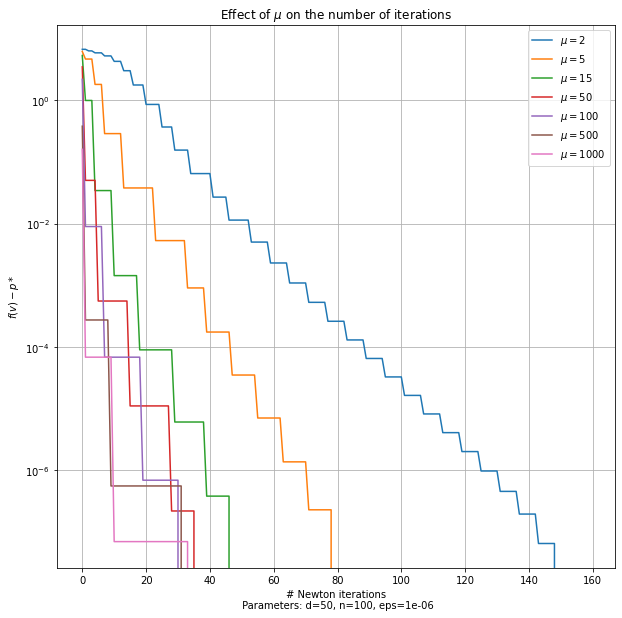

In [5]:
plt.figure(figsize=[10,10])
plt.title(f"Effect of $\mu$ on the number of iterations")
plt.grid()
for g in gaps:
  plt.semilogy(g)
plt.legend([f"$\mu = {mu}$" for mu in mus])
plt.xlabel(f"# Newton iterations\n Parameters: d={d}, n={n}, eps={eps}")
plt.ylabel("$f(v) - p*$")

#### Comments about central values
In the previous section I plot the gap $f(v) - p^*$ at the central points (the last value from the previous inner iteration) at each inner iteration, so we have the total number of iterations on the x-axis. That's why we observe the staircase structure, where the "width" of each step indicates the number of inner iterations to find the next central value, and the "height" between steps shows the gap between two consecutive central points. 

Note that we have guarantees that at each inner (Newton) iteration the objective function, including the logarithmic barrier, $tf(v) + \phi(v)$ decreases. That was verified, however I observed that in some inner iterations, the value of $f(v)$ increases a little, because the net decrease is still positive, because of the decrease on the barrier. Finally, by observing only the gap at central points (where we know that we have primal and dual feasibility), we always observe a decrease on the value of the function. This can be explained because, at central points, the gap is $f(v^*(t) - p^* \leq \frac{m}{t}$, so when increasing $t$ the gap will decrease (Page 566 of [Convex Optimization – Boyd and Vandenberghe
](https://web.stanford.edu/~boyd/cvxbook/))

#### Changes in iterations when changing $\mu$
First, we see that after some threshold value $\mu\approx15$, the number of iterations is not at all sensitive to the changes of $\mu$. Then, we can observe the trade-off between inner and outer iterations. When $\mu$ is small, we need much more outer iterations for convergence (because we're increasing the barrier slowly), but the number of inner iterations is smaller for each central value. I.e we need less Newton steps to converge at each outer step, but we need more outer steps to find the solution. The converse is observed when $\mu$ increases. If we assume the cost per iteration is fixed, we should select a value of $\mu$ that minimizes the total number of them. Based on the experiments I did, I'd say that an appropiate value for this problem should be $\mu \in [50, 100]$.

### Value of $w$

Because we have a convex problem, we know that if $t^*, w^*$ satisfy KKT conditions, then $t^*, w^*$ are optimal.

Let's consider the first order condition for the gradient of the Lagrangian
$\nabla L(t^*) = 
0 \iff t^*=-v^*$. 

Now, consider the primal feasibility:

$t^* = Xw^*-y \implies w^* = X^+(y-v^*)$ Where $X^+$ is the pseudo-inverse of $X$.




In [6]:
# Test data
eps = 1e-6
d = 200
n = 500
lam = 10
np.random.seed(42)
X = np.random.rand(n, d)
y = np.random.rand(n)

A = np.concatenate([X, -X], axis=1).T
Q = np.eye(n) * 0.5
p = -y
b = np.ones(2*d) * lam
# feasible point
v0 = np.zeros(n)

# Iterating over different mu values
ws = []
mus = [2, 15, 30, 50, 100, 500]
for mu in mus:
  v_seq = barrier_method(Q, p, A, b, v0, eps, mu)
  v = v_seq[-1][-1]
  # Compute w from v*
  ws.append(np.dot(np.linalg.pinv(X),(y-v)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log


Text(0, 0.5, 'Value of the i-th component')

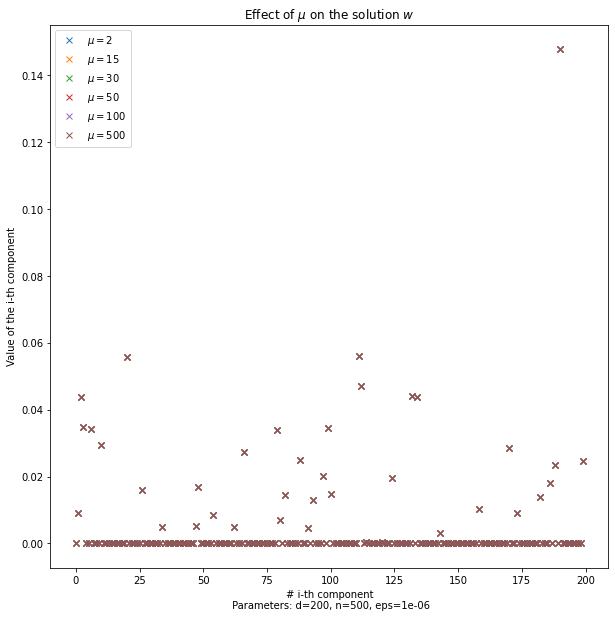

In [7]:
plt.figure(figsize=[10,10])
plt.title(f"Effect of $\mu$ on the solution $w$")
for w in ws:
  plt.plot(w, 'x')
plt.legend([f"$\mu = {mu}$" for mu in mus])
plt.xlabel(f"# i-th component\n Parameters: d={d}, n={n}, eps={eps}")
plt.ylabel("Value of the i-th component")

The solution is completely stable at changes of $\mu$. Despite considering different "paths" to optimize the problem, we always arrive at the same point. It was something I expected and it's great that we're able to verify it. This means that we can change this parameter without worrying about not converging to the solution.

Finally, by looking at the different coefficients of the solution $w$, we can see how LASSO regression enforces getting a sparse solution, where most of its coefficients are 0.